<a href="https://colab.research.google.com/github/keinam53/Deep_learning/blob/main/2_Keras/3_Niedouczenie_przeuczenie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Główne problemy uczenia maszynowego: przeuczenie (overfitting) oraz niedouczenie (underfitting)

>Celem tego notebook'a jest pokazanie przykładów zbyt dobrego dopasowanie modelu do danych uczących (przeuczenie) oraz zbyt słabego dopasowania modelu do danych uczących (niedouczenie).
>
>Wykorzystamy zbiór z bilioteki Keras składający się z 50000 recenzji filmów oznaczonych sentymentem: pozytywny/negatywny. Recenzje są wstępnie przetworzone, a każda recenzja jest zakodowana jako sekwencja indeksów słów. Słowa są indeksowane według ogólnej częstotliwości w zbiorze danych. Na przykład liczba 5 oznacza piąte najczęściej pojawiające się słowo w danych. Liczba 0 nie oznacza określonego słowa.

### Spis treści
1. [Import bibliotek](#a1)
2. [Załadowanie i przygotowanie danych](#a2)
3. [Budowa modelu bazowego](#a3)
4. [Budowa 'mniejszego' modelu](#a4)    
5. [Budowa 'większego' modelu](#a5)
6. [Porównanie wydajności modeli](#a6)
7. [Metody regularyzacji](#a7)

### <a name='a1'></a> 1. Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.datasets.imdb import get_word_index
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.printoptions(precission=6, suppress=True)
sns.set()
tf.__version__

'2.6.0'

### <a name='a2'></a> 2. Załadowanie i przygotowanie danych

In [2]:
NUM_WORDS = 10000   #10000 najczęściej występujących słów
INDEX_FROM = 3

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)

print(f'train data shape: {train_data.shape}')
print(f'test data shape: {test_data.shape}')

train data shape: (25000,)
test data shape: (25000,)


In [3]:
print(train_data[1])

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


In [4]:
word_to_idx = get_word_index()
word_to_idx = {k:(v + INDEX_FROM) for k, v in word_to_idx.items()}
word_to_idx['<PAD>'] = 0
word_to_idx['<START>'] = 1
word_to_idx['<UNK>'] = 2
word_to_idx['<UNUSED>'] = 3
idx_to_word = {v: k for k, v in word_to_idx.items()}
list(idx_to_word.items())[:10]
print(' '.join(idx_to_word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [5]:
train_labels[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [6]:
def multi_hot_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

print(train_data.shape)
print(test_data.shape)

(25000, 10000)
(25000, 10000)


### <a name='a3'></a> 3. Budowa modelu bazowego

In [7]:
baseline_model = Sequential()
baseline_model.add(Dense(units=16, activation='relu', input_shape=(NUM_WORDS,)))
baseline_model.add(Dense(units=16, activation='relu'))
baseline_model.add(Dense(units=1, activation='sigmoid'))

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [8]:
baseline_history = baseline_model.fit(train_data, train_labels, epochs=20, batch_size=512, 
                                      validation_data=(test_data, test_labels))

Epoch 1/20
49/49 [==============================] - 3s 53ms/step - loss: 0.4506 - accuracy: 0.8162 - binary_crossentropy: 0.4506 - val_loss: 0.3126 - val_accuracy: 0.8805 - val_binary_crossentropy: 0.3126
Epoch 2/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2311 - accuracy: 0.9157 - binary_crossentropy: 0.2311 - val_loss: 0.2880 - val_accuracy: 0.8838 - val_binary_crossentropy: 0.2880
Epoch 3/20
49/49 [==============================] - 2s 38ms/step - loss: 0.1692 - accuracy: 0.9414 - binary_crossentropy: 0.1692 - val_loss: 0.2977 - val_accuracy: 0.8834 - val_binary_crossentropy: 0.2977
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1368 - accuracy: 0.9541 - binary_crossentropy: 0.1368 - val_loss: 0.3231 - val_accuracy: 0.8777 - val_binary_crossentropy: 0.3231
Epoch 5/20
49/49 [==============================] - 2s 40ms/step - loss: 0.1109 - accuracy: 0.9645 - binary_crossentropy: 0.1109 - val_loss: 0.3572 - val_accuracy: 0.8722 - val_bin

### <a name='a4'></a> 4. Budowa 'mniejszego' modelu

In [9]:
smaller_model = Sequential()
smaller_model.add(Dense(units=4, activation='relu', input_shape=(NUM_WORDS,)))
smaller_model.add(Dense(units=4, activation='relu'))
smaller_model.add(Dense(units=1, activation='sigmoid'))

smaller_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [10]:
smaller_history = smaller_model.fit(train_data, train_labels, epochs=20, batch_size=512, 
                                      validation_data=(test_data, test_labels))

Epoch 1/20
49/49 [==============================] - 3s 51ms/step - loss: 0.6308 - accuracy: 0.6254 - binary_crossentropy: 0.6308 - val_loss: 0.5734 - val_accuracy: 0.7266 - val_binary_crossentropy: 0.5734
Epoch 2/20
49/49 [==============================] - 2s 37ms/step - loss: 0.5212 - accuracy: 0.8054 - binary_crossentropy: 0.5212 - val_loss: 0.5112 - val_accuracy: 0.8361 - val_binary_crossentropy: 0.5112
Epoch 3/20
49/49 [==============================] - 2s 37ms/step - loss: 0.4625 - accuracy: 0.8701 - binary_crossentropy: 0.4625 - val_loss: 0.4760 - val_accuracy: 0.8509 - val_binary_crossentropy: 0.4760
Epoch 4/20
49/49 [==============================] - 2s 37ms/step - loss: 0.4192 - accuracy: 0.9025 - binary_crossentropy: 0.4192 - val_loss: 0.4490 - val_accuracy: 0.8753 - val_binary_crossentropy: 0.4490
Epoch 5/20
49/49 [==============================] - 2s 36ms/step - loss: 0.3818 - accuracy: 0.9224 - binary_crossentropy: 0.3818 - val_loss: 0.4288 - val_accuracy: 0.8768 - val_bin

### <a name='a5'></a> 5. Budowa 'większego' modelu

In [11]:
bigger_model = Sequential()
bigger_model.add(Dense(units=512, activation='relu', input_shape=(NUM_WORDS,)))
bigger_model.add(Dense(units=512, activation='relu'))
bigger_model.add(Dense(units=1, activation='sigmoid'))

bigger_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [12]:
bigger_history = bigger_model.fit(train_data, train_labels, epochs=20, batch_size=512, 
                                      validation_data=(test_data, test_labels))

Epoch 1/20
49/49 [==============================] - 16s 324ms/step - loss: 0.3479 - accuracy: 0.8494 - binary_crossentropy: 0.3479 - val_loss: 0.2930 - val_accuracy: 0.8809 - val_binary_crossentropy: 0.2930
Epoch 2/20
49/49 [==============================] - 15s 316ms/step - loss: 0.1407 - accuracy: 0.9471 - binary_crossentropy: 0.1407 - val_loss: 0.3283 - val_accuracy: 0.8746 - val_binary_crossentropy: 0.3283
Epoch 3/20
49/49 [==============================] - 16s 321ms/step - loss: 0.0452 - accuracy: 0.9869 - binary_crossentropy: 0.0452 - val_loss: 0.4538 - val_accuracy: 0.8664 - val_binary_crossentropy: 0.4538
Epoch 4/20
49/49 [==============================] - 16s 319ms/step - loss: 0.0063 - accuracy: 0.9990 - binary_crossentropy: 0.0063 - val_loss: 0.5957 - val_accuracy: 0.8690 - val_binary_crossentropy: 0.5957
Epoch 5/20
49/49 [==============================] - 15s 315ms/step - loss: 7.8173e-04 - accuracy: 1.0000 - binary_crossentropy: 7.8173e-04 - val_loss: 0.6865 - val_accuracy

In [13]:
hist = pd.DataFrame(baseline_history.history)
hist['epoch'] = baseline_history.epoch
hist.head()

,loss,accuracy,binary_crossentropy,val_loss,val_accuracy,val_binary_crossentropy,epoch
0,0.450605,0.81624,0.450605,0.312583,0.88048,0.312583,0
1,0.231061,0.91568,0.231061,0.288044,0.88384,0.288044,1
2,0.169175,0.94136,0.169175,0.297691,0.88336,0.297691,2
3,0.136803,0.95408,0.136803,0.323134,0.87768,0.323134,3
4,0.110934,0.96452,0.110934,0.357209,0.87216,0.357209,4


### <a name='a6'></a> 6. Porównanie wydajności modeli

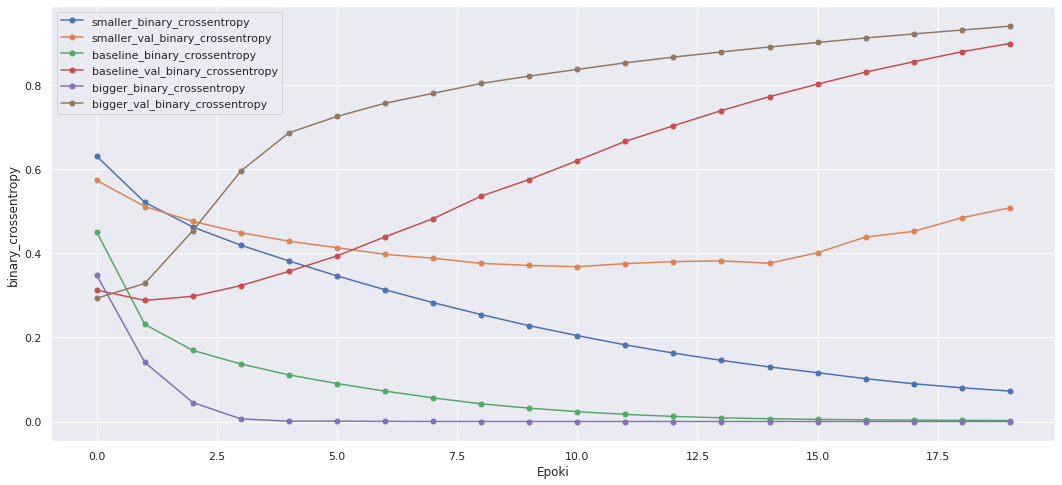

In [14]:
plt.figure(figsize=(18, 8))
for name, history in zip(['smaller', 'baseline', 'bigger'], [smaller_history, baseline_history, bigger_history]):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.plot(hist['epoch'], hist['binary_crossentropy'], marker = '.', markersize = 10, label=name + '_binary_crossentropy',)
    plt.plot(hist['epoch'], hist['val_binary_crossentropy'], marker = '.', markersize = 10, label=name + '_val_binary_crossentropy',)
    plt.xlabel('Epoki')
    plt.ylabel('binary_crossentropy')
    plt.legend()
plt.show()

### <a name='a7'></a> 7. Metody regularyzacji

In [15]:
from tensorflow.keras.regularizers import l2

l2_model = Sequential()
l2_model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.001), input_shape=(NUM_WORDS,)))
l2_model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.01)))
l2_model.add(Dense(units=1, activation='sigmoid'))

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [16]:
l2_model_history = l2_model.fit(train_data, train_labels, epochs=20, batch_size=512, 
                                validation_data=(test_data, test_labels))

Epoch 1/20
49/49 [==============================] - 3s 58ms/step - loss: 0.6544 - accuracy: 0.8150 - binary_crossentropy: 0.4820 - val_loss: 0.5059 - val_accuracy: 0.8783 - val_binary_crossentropy: 0.3443
Epoch 2/20
49/49 [==============================] - 2s 41ms/step - loss: 0.4222 - accuracy: 0.9091 - binary_crossentropy: 0.2664 - val_loss: 0.4364 - val_accuracy: 0.8884 - val_binary_crossentropy: 0.2881
Epoch 3/20
49/49 [==============================] - 2s 41ms/step - loss: 0.3558 - accuracy: 0.9255 - binary_crossentropy: 0.2136 - val_loss: 0.4188 - val_accuracy: 0.8858 - val_binary_crossentropy: 0.2837
Epoch 4/20
49/49 [==============================] - 2s 41ms/step - loss: 0.3178 - accuracy: 0.9350 - binary_crossentropy: 0.1879 - val_loss: 0.4130 - val_accuracy: 0.8825 - val_binary_crossentropy: 0.2886
Epoch 5/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2932 - accuracy: 0.9420 - binary_crossentropy: 0.1725 - val_loss: 0.4064 - val_accuracy: 0.8821 - val_bin

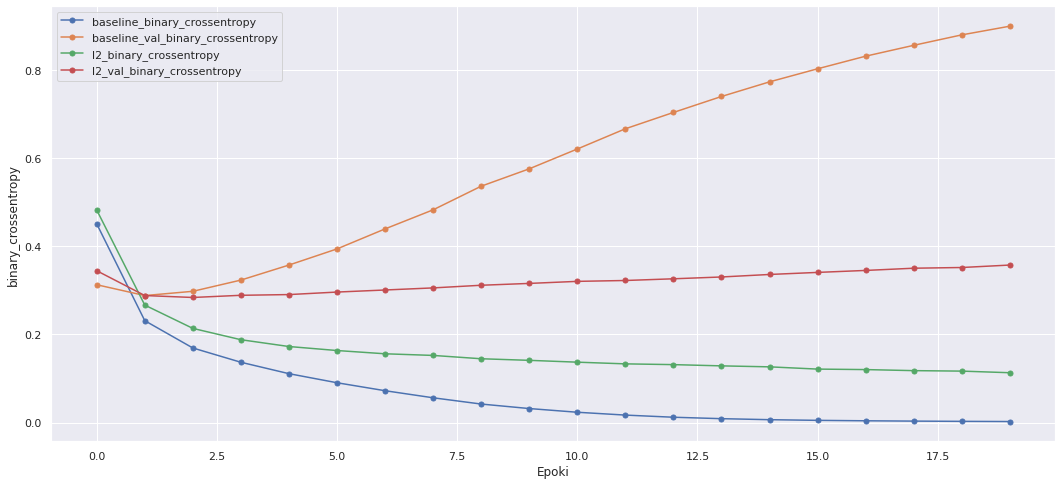

In [17]:
plt.figure(figsize=(18, 8))
for name, history in zip(['baseline', 'l2'], [baseline_history, l2_model_history]):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.plot(hist['epoch'], hist['binary_crossentropy'], marker = '.', markersize = 10, label=name + '_binary_crossentropy',)
    plt.plot(hist['epoch'], hist['val_binary_crossentropy'], marker = '.', markersize = 10, label=name + '_val_binary_crossentropy',)
    plt.xlabel('Epoki')
    plt.ylabel('binary_crossentropy')
    plt.legend()
plt.show()

In [18]:
from tensorflow.keras.layers import Dropout

dropout_model = Sequential()
dropout_model.add(Dense(units=16, activation='relu', input_shape=(NUM_WORDS,)))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(units=16, activation='relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(units=1, activation='sigmoid'))

dropout_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

dropout_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [21]:
dropout_model_history = dropout_model.fit(train_data, train_labels, epochs=20, batch_size=512, 
                                          validation_data=(test_data, test_labels))

Epoch 1/20
49/49 [==============================] - 3s 50ms/step - loss: 0.6468 - accuracy: 0.6182 - binary_crossentropy: 0.6468 - val_loss: 0.5272 - val_accuracy: 0.8465 - val_binary_crossentropy: 0.5272
Epoch 2/20
49/49 [==============================] - 2s 43ms/step - loss: 0.4852 - accuracy: 0.7923 - binary_crossentropy: 0.4852 - val_loss: 0.3603 - val_accuracy: 0.8807 - val_binary_crossentropy: 0.3603
Epoch 3/20
49/49 [==============================] - 2s 43ms/step - loss: 0.3727 - accuracy: 0.8587 - binary_crossentropy: 0.3727 - val_loss: 0.2955 - val_accuracy: 0.8878 - val_binary_crossentropy: 0.2955
Epoch 4/20
49/49 [==============================] - 2s 43ms/step - loss: 0.2980 - accuracy: 0.8966 - binary_crossentropy: 0.2980 - val_loss: 0.2762 - val_accuracy: 0.8896 - val_binary_crossentropy: 0.2762
Epoch 5/20
49/49 [==============================] - 2s 44ms/step - loss: 0.2495 - accuracy: 0.9172 - binary_crossentropy: 0.2495 - val_loss: 0.2752 - val_accuracy: 0.8901 - val_bin

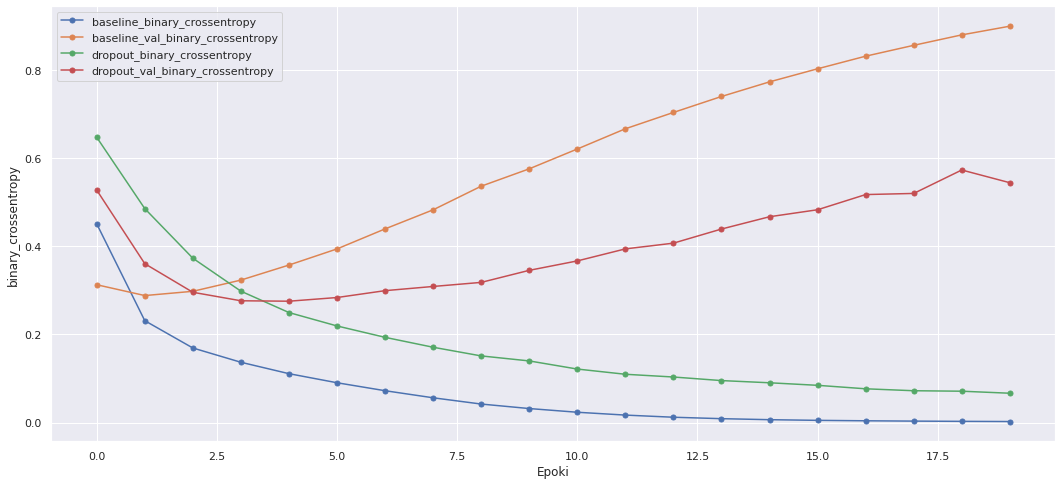

In [22]:
plt.figure(figsize=(18, 8))
for name, history in zip(['baseline', 'dropout'], [baseline_history, dropout_model_history]):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.plot(hist['epoch'], hist['binary_crossentropy'], marker = '.', markersize = 10, label=name + '_binary_crossentropy',)
    plt.plot(hist['epoch'], hist['val_binary_crossentropy'], marker = '.', markersize = 10, label=name + '_val_binary_crossentropy',)
    plt.xlabel('Epoki')
    plt.ylabel('binary_crossentropy')
    plt.legend()
plt.show()